In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.process.lsf import LSF
from spectacle.analysis.metrics import correlate, npcorrelate, cross_correlate, autocorrelate
import matplotlib.pyplot as plt
import numpy as np
import uncertainties.unumpy as unp

INFO:root:Added misty to custom loaders.
INFO:root:Added my-format to custom loaders.


In [2]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [12, 8]

# Correlation Metric Analysis

This notebook goes through a few different correlation metrics being explored right now.

<IPython.core.display.Javascript object>


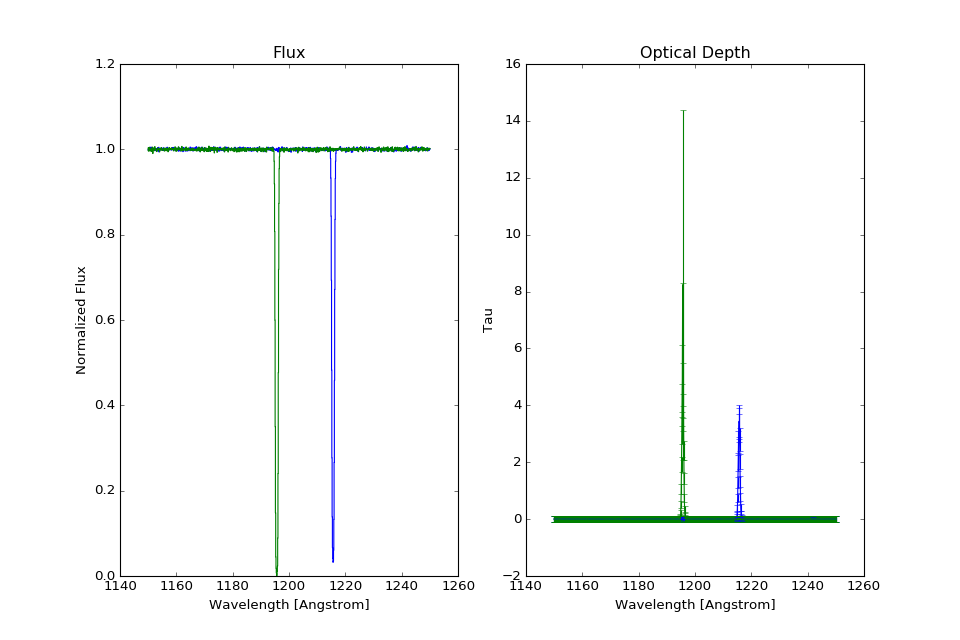

In [13]:
# Generate two spectrums to use for correlation

disp = np.linspace(1150, 1250, 1000)

line = Line(name="HI", lambda_0=1.21567010E+03, v_doppler=1e7, column_density=10**14.66)
spectrum_model1 = Absorption1D(lines=[line])

spectrum1 = spectrum_model1(disp)
# spectrum1 = Spectrum1D(flux, dispersion=disp, lines=[line])
spectrum1.add_noise(0.0025)
spectrum1.uncertainty = np.sqrt(spectrum1.data * 0.01)

line = Line(name="HI2", lambda_0=1.19567010E+03, v_doppler=1e7, column_density=10**14.66)
spectrum_model2 = Absorption1D(lines=[line])

spectrum2 = spectrum_model2(disp)
# spectrum2 = Spectrum1D(flux, dispersion=disp, lines=[line])
spectrum2.add_noise(0.0025)
spectrum2.uncertainty = np.sqrt(spectrum2.data * 0.01)

# mask = (spectrum1.dispersion > 1150) & (spectrum1.dispersion < 1250)
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.step(spectrum1.dispersion, spectrum1.data)#, yerr=spectrum1.uncertainty)
ax1.step(spectrum2.dispersion, spectrum2.data)#, yerr=spectrum2.uncertainty)

ax2.errorbar(spectrum1.dispersion, spectrum1.tau, yerr=spectrum1.tau_uncertainty)
ax2.errorbar(spectrum2.dispersion, spectrum2.tau, yerr=spectrum2.tau_uncertainty)

ax1.set_title("Flux")
ax1.set_ylabel("Normalized Flux")
ax1.set_xlabel("Wavelength [Angstrom]")

ax2.set_title("Optical Depth")
ax2.set_ylabel("Tau")
ax2.set_xlabel("Wavelength [Angstrom]")

plt.show()

## Peeples Correlation

### True

/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Sum: 0.860352099800579
Tau Sum: 8.144981019990387e-05


<IPython.core.display.Javascript object>


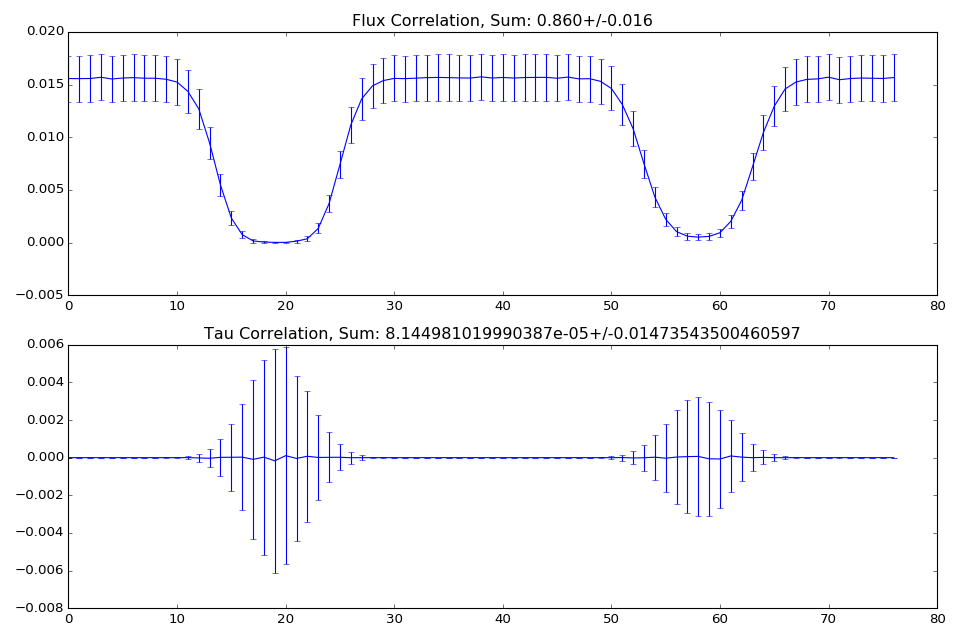

In [4]:
vals, uncerts, use_mask = correlate(spectrum1, spectrum2)
tvals, tuncerts, use_mask = correlate(spectrum1, spectrum2, use_tau=True)

flux_sum = unp.uarray(vals, uncerts).sum()
tau_sum = unp.uarray(tvals, tuncerts).sum()

print("Sum: {}".format(flux_sum.nominal_value, flux_sum.std_dev))
print("Tau Sum: {}".format(tau_sum.nominal_value, tau_sum.std_dev))

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}+/-{}".format(tau_sum.nominal_value, tau_sum.std_dev))

plt.tight_layout()
plt.show()

### Lite

Sum: (1.3+/-1.5)e+03
Tau Sum: (0+/-7)e+07


<IPython.core.display.Javascript object>


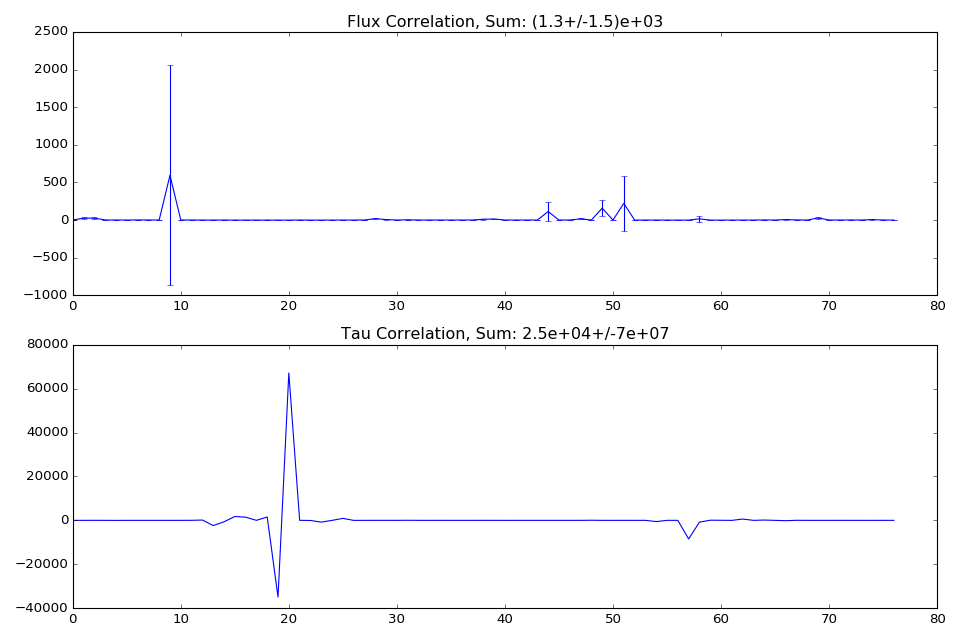

In [5]:
vals, uncerts, use_mask = correlate(spectrum1, spectrum2, mode='lite')
tvals, tuncerts, use_mask = correlate(spectrum1, spectrum2, mode='lite', use_tau=True)

tau_sum = unp.uarray(tvals, tuncerts).sum()

print("Sum: {}".format(unp.uarray(vals, uncerts).sum()))
print("Tau Sum: {}".format(tau_sum))

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals)#, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {:.2}+/-{:.2}".format(tau_sum.nominal_value, tau_sum.std_dev))

plt.tight_layout()
plt.show()

### Full

Sum: (2.4+/-3.2)e+02
Tau Sum: (0.0+/-2.1)e+10


<IPython.core.display.Javascript object>


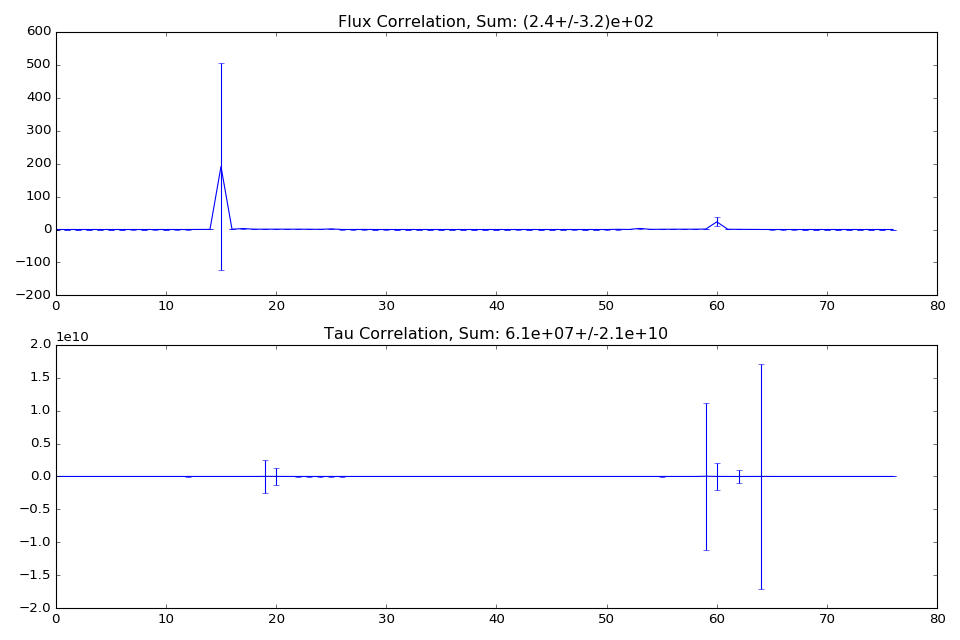

In [6]:
vals, uncerts, use_mask = correlate(spectrum1, spectrum2, mode='full')
tvals, tuncerts, use_mask = correlate(spectrum1, spectrum2, mode='full', use_tau=True)

flux_sum = unp.uarray(vals, uncerts).sum()
tau_sum = unp.uarray(tvals, tuncerts).sum()

print("Sum: {}".format(flux_sum))
print("Tau Sum: {}".format(tau_sum))

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {:.2}+/-{:.2}".format(tau_sum.nominal_value, tau_sum.std_dev))

plt.tight_layout()
plt.show()

## Numpy Correlate

### `Valid` mode
Mode ‘valid’ returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely. Values outside the signal boundary have no effect.

In [7]:
vals, uncerts, use_mask = npcorrelate(spectrum1, spectrum2)
tvals, tuncerts, use_mask = npcorrelate(spectrum1, spectrum2, use_tau=True)

print(unp.uarray(vals, uncerts))
print(unp.uarray(tvals, tuncerts))

[55.02201870738054+/-1.0292824828121128]
[0.008761974900632997+/-1.5851702768216327]


### `Same` mode
Mode ‘same’ returns output of length max(M, N). Boundary effects are still visible.

<IPython.core.display.Javascript object>


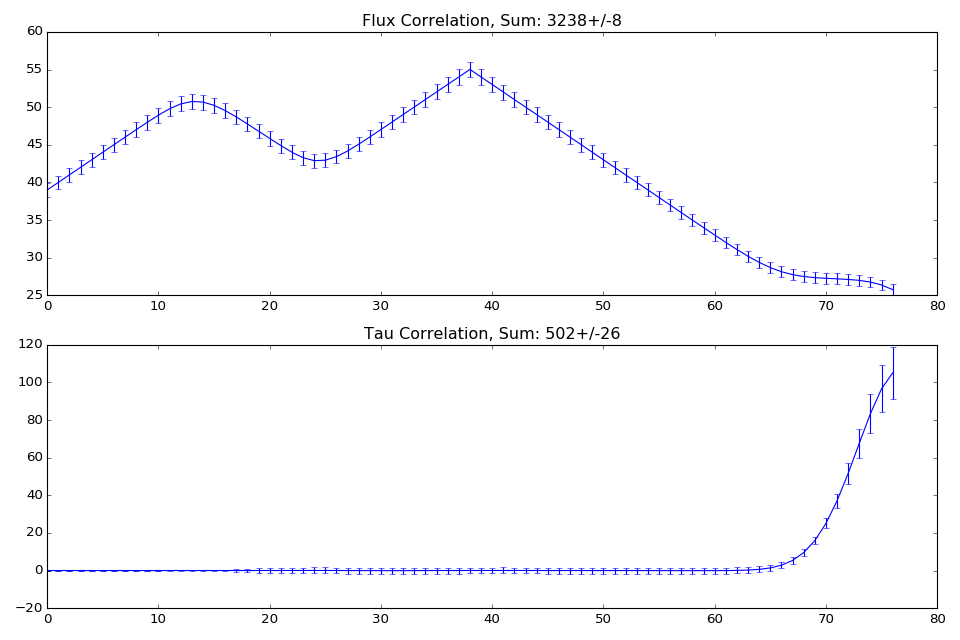

In [8]:
vals, uncerts, use_mask = npcorrelate(spectrum1, spectrum2, mode='same')
tvals, tuncerts, use_mask = npcorrelate(spectrum1, spectrum2, mode='same', use_tau=True)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}".format(unp.uarray(tvals, tuncerts).sum()))

plt.tight_layout()
plt.show()

### `Full` mode
By default, mode is ‘full’. This returns the convolution at each point of overlap, with an output shape of (N+M-1,). At the end-points of the convolution, the signals do not overlap completely, and boundary effects may be seen.

<IPython.core.display.Javascript object>


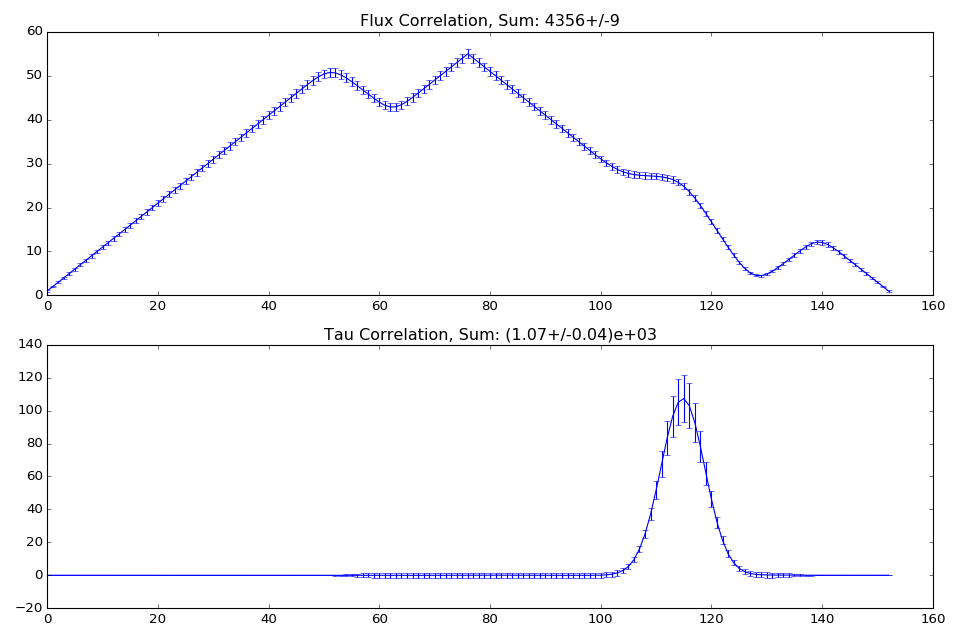

In [9]:
vals, uncerts, use_mask = npcorrelate(spectrum1, spectrum2, mode='full')
tvals, tuncerts, use_mask = npcorrelate(spectrum1, spectrum2, mode='full', use_tau=True)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}".format(unp.uarray(tvals, tuncerts).sum()))

plt.tight_layout()
plt.show()

## Peeples Autocorrelate

In [10]:
res1 = autocorrelate(spectrum1)
res2 = autocorrelate(spectrum2)
tres1 = autocorrelate(spectrum1, use_tau=True)
tres2 = autocorrelate(spectrum2, use_tau=True)

print("Spectrum1: {}".format(unp.uarray(*res1)))
print("Spectrum2: {}".format(unp.uarray(*res2)))

print("Tau Spectrum1: {}".format(unp.uarray(*tres1)))
print("Tau Spectrum2: {}".format(unp.uarray(*tres2)))

Spectrum1: 1.00783+/-0.00026
Spectrum2: 1.00985+/-0.00024
Tau Spectrum1: 96+/-24
Tau Spectrum2: 99+/-16
